# Icentia11k Dataset

> About the Icentia 11k dataset (size, classes) & train/test splits 

In [1]:
from pathlib import Path
import logging

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wfdb

from ecg_classification.data_loader import Icentia11k

In [2]:
logging.basicConfig(level=logging.INFO)

## Overview of Icentia11k

### Purpose

Icentia11k is (as of 2019) the largest public ECG dataset of continuous raw signals containing 11 thousand patients and 2 billion labelled beats.
The purpose of the dataset is to enable semi-supervised ECG models to be made as well as to discover unknown subtypes of arrhythmia and anomalous ECG signal events.

### Collection Methods

The ECG recordings were obtained using a single-lead portable ECG device ([CartioSTAT](https://www.cardiostat.com/) by [Icentia](https://www.icentia.com/)).
Patents wore the device betwen 3 - 14 days.

### Dataset Statistics

The sample rate was 250 Hz. The total dataset size 271.27GB.

### Patient demographics

| Attribute | Characteristic |
|--|--|
| Age | Average $62.2 \pm 17.4$ years of age |
| Sex | $42.6 \%$ male, $45.3 %$ female, $12.2 \%$ unknown |

### Privacy

Patients are identified only by a random integer ID

### Authors

The dataset was published by Tan et al. 2019. For more information, refer to the paper [Icentia11k: An Unsupervised ECG Representation Learning Dataset for Arrhythmia Subtype Discovery](https://arxiv.org/pdf/1910.09570v1) and refer to the dataset hosted at [PhysioNet](https://physionet.org/content/icentia11k-continuous-ecg/1.0/)

## Example

Below we show an example labelled ECG recording from the dataset 

In [8]:
# Tan et al. (Icentia11k) use a frame length of 2049.
# However, we choose to use a smaller frame length to accomodate our DeepBeat-inspired model, which accepts a frame length of 800
dataset = Icentia11k(Path("../data/icentia11k"), frame_length=800)
patient_segments = np.array([
    [9000, 0], # Example normal beat & rhythm
    [900, 0], # Example segment with abnormal beat 
    [1100, 0]]) # Example segment with abnormal rhythm
dataset.create(patient_segments, overwrite=True)
dataset.print_summary()


Dataset Summary
-------
3930 frames across 3 patients
1.0 segments per patient

Class distribution (%)
--------
abnormal beats     26.28
abnormal rhythm     2.80
dtype: float64


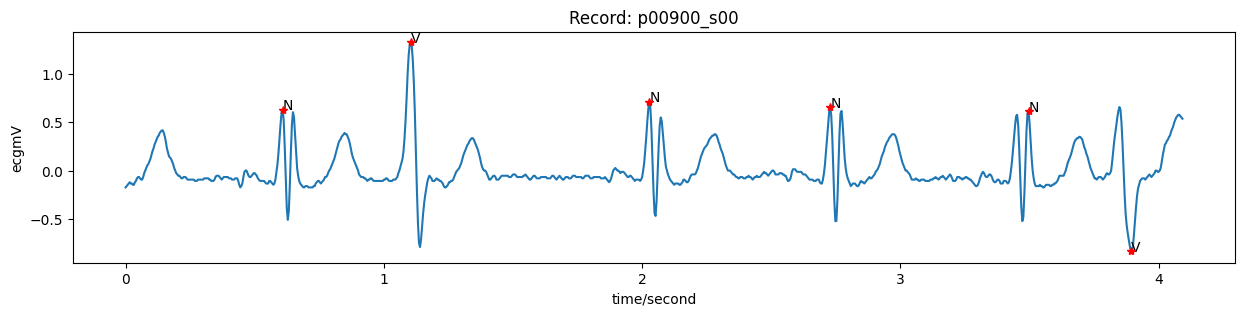

In [4]:
# An example frame from the dataset
rec, ann = dataset.get_recording(patient_id=900, segment_id=0, start=2000, length=1024)

wfdb.plot_wfdb(rec, ann, plot_sym=True, figsize=(15, 3))

## We Use Only the Fully-Labelled Subset

The dataset conists of ECG recordings for each patient.
Patient IDs 9,000 - 10,999 are gauranteed to have fully labelled recordings. Other patients with IDs < 9000 may or may not have labels. 

> The authors originally intended data from patients 9,000 - 10,999 to be the evaluation subset for unsupervised models trained on partially labelled recordings for patient IDs <9000.
However, for our supervised ECG classification task, there is enough data in the intended 'test' set alone to produce a substantial train/test split.
However, this means we cannot compare our work to the baseline model performance reported in Tan et al. 2019.

## The Data is Hierarchical


A recording for a given patient is not continuous; instead the authors randomly selected 50 ~70min segments for a given patient.

> Note that not all patients have 50 segments of data. For example, p9894 only has 40 segments [(refer to dataset files on PhysioNet)](https://physionet.org/files/icentia11k-continuous-ecg/1.0/p09/p09894/)

```shell
p##### # <- patient ##### (9,000 to 10,999)
    s## # <- segment ## (0 - 49)
        p#####.atr # <- Attributes/annotations for ECG recording
        p#####.hea # <- Header/metadata for ECG recording
        p#####.dat # <- ECG recording data
```

A segment is really large (1,048,577 measurements per segment), so we will split a segment into a number of frames of a fixed window-size. So, the data will be hierarchical:

```shell
Patient i
    Segment j
        Frame k
```



### Implications for Model Building => Grouped K-Fold Cross Validation

When performing cross-validation, we need to ensure that data we split frames into training and validation sets according to **patients**. This is because frames from the same segment are associated (e.g. temporally), and segments from the same patient are associated (e.g. because the same patient produces the segments).

In other words, we need to perform repeated **Grouped K-fold Cross Validation**, where we group by patients.
We can use the [GroupKFold - Scikit-Learn](https://scikit-learn.org/stable/modules/cross_validation.html#group-k-fold)

## Class Imbalance

From Table 2 in [Tan et al. 2019](https://www.cinc.org/2021/Program/accepted/229_Preprint.pdf)

Beat labels in the evaluation set

| Beat labels | Count | Proportion |
|---|---|---|
| Normal                                | 174,249   | 0.6271 |
| Premature Atrial Contractions         | 58,780    | 0.2115 |
| Premature Ventricular contractions    | 44_835    | 0.1614 |

Rhythm labels in the evaluation set

| Rhythm Labels | Count | Proportion |
|---|---|---|
| NSR(Normal Sinusal Rhythm) |   261,377 | 0.941 |
| AFib (Atrial Fibrillation) |   13,056  | 0.047 |
| AFlutter (Atrial Flutter)  |   3,330   | 0.012 |


### Implications for Modelling => Stratified, Group K-Fold AND/OR Oversampling

[SMOTE]()

[StratifiedGroupKFold - Scikit-Learn](https://scikit-learn.org/stable/modules/cross_validation.html#stratifiedgroupkfold)

## Downloading the Dataset

We have written some code to make it easier to download, store, and process the dataset.
Run the sample below to create the dataset, making sure to adjust the size of the dataset according to your computer storage, network, and processing limitations.

> For reference, downloading and processing 35 patient-segment pairs takes around 10min and takes about around 37M of space (23M for the numpy arrays and, optionally, 14M for storing the compressed wfdb files) on WSL2 (Windows) with an intl i7 core processor.

In [10]:
# Patients with known abnormalities - we found these by searching through the icentia dataset
patient_segments = np.array([
    [900, 0],
    [1100, 0],
    [9000, 0], # Normal
    [9001, 0],
    [9154, 3],
    [9176, 3],
    [9184, 3],
    [9185, 3],
    [9314, 3],
    [9314, 5],
    [9376, 5],
    [9428, 15],
    [9440, 15],
    [9596, 19],
    [9634, 19],
    [9635, 19],
    [9764, 22],
    [9772, 22],
    [9894, 22],
    [9894, 29],
    [9894, 30],
    [9909, 30],
    [9946, 31],
    [9974, 31],
    [10278, 33],
    [10351, 33],
    [10413, 33],
    [10498, 33],
    [10515, 37],
    [10532, 39],
    [10532, 41],
    [10674, 41],
    [10907, 45],
    [10951, 45],
    [10951, 46],
    [10988, 48]])

dataset.create(patient_segments)
dataset.print_summary()


Dataset Summary
-------
47160 frames across 31 patients
1.1613 segments per patient

Class distribution (%)
--------
abnormal beats     7.57
abnormal rhythm    0.66
dtype: float64
